# Supervised Model Project

## Load the Libraries

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from GUI_models import train_predict
from Models import *
from Models import AdaBoost, Decision_Tree
from Models import GradientBoost, KNN, Linear_Discriminant
from Models import Logistic_reg, Naive_Bayes, SVC
from Models import Random_Forest, SGD, Quadratic_Discriminant
from joblib import load
from os.path import dirname, basename, isfile, join
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import tkinter as tk
import pandas as pd
from pandastable import Table, TableModel

## Create the functions, classes, and dictionaries for this notebook

In [2]:
class DataFrameTable(tk.Frame):
    def __init__(self, parent=None, df=pd.DataFrame()):
        super().__init__()
        self.parent = parent
        self.pack(fill=tk.BOTH, expand=True)
        self.table = Table(
            self, dataframe=df,
            showtoolbar=False,
            showstatusbar=True,
            editable=False)
        self.table.show()


def _quit():
    root.quit()
    root.destroy()


def _stop():
    """Stop scanning by setting the global flag to False."""
    global running
    root.quit()
    root.destroy()
    running = False


fun_dict = {
    'AdaBoost': AdaBoost.train_AdaBoost,
    'Decision_Tree': Decision_Tree.train_Decision_Tree,
    'GradientBoost': GradientBoost.train_GradientBoost,
    'KNN': KNN.train_KNN,
    'Linear_Discriminant':
        Linear_Discriminant.train_Linear_Discriminant,
    'Logistic_reg': Logistic_reg.train_Logistic_reg,
    'Naive_Bayes': Naive_Bayes.train_Naive_Bayes,
    'SVC': SVC.train_SVC,
    'Random_Forest': Random_Forest.train_Random_Forest,
    'SGD': SGD.train_SGD,
    'Quadratic_Discriminant':
        Quadratic_Discriminant.train_Quadratic_Discriminant
}

## Load the Data

In [3]:
df = pd.read_csv('Data_For_Model.csv')
X = df.iloc[:, 1::].values
y = df.iloc[:, 0].values
# Split the data into train and validation. The training set will be
# used later in k-cross validation, so it remains as X, and y
X_train, X_validation, y_train, y_validation = \
    train_test_split(X, y, test_size=0.3,
                     random_state=42)

## Run the GUI, where it asks whether the user wants to train, predict or check the performance of the current classifiers

In [4]:
running = True

while running:

    action = train_predict.train_predict_check()

    if action == 1:
        # Load the classification models
        classifiers = train_predict.train()
        clf_dict = {}
        for clf in classifiers:
            clf_dict[clf] = fun_dict[clf](X_train, y_train)

        cols = ['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1Score']
        df_metrics = pd.DataFrame(columns=cols)
        clfs = list(fun_dict.keys())

        for clf in clfs:

            model = load(f'Models/{clf}_model.joblib')
            y_pred = model.predict(X_validation)
            accu = accuracy_score(y_validation, y_pred)
            prec = precision_score(y_validation, y_pred, average='weighted')
            recall = recall_score(y_validation, y_pred, average='weighted')
            f1 = f1_score(y_validation, y_pred, average='weighted')
            new_entry = pd.DataFrame([[clf, accu, prec, recall, f1]],
                                     columns=cols)
            df_metrics = df_metrics.append(new_entry, ignore_index=True)

        df_metrics.to_csv('Models/Metrics.csv', index=False)

    elif action == 2:
                # Get information for the next round
        # Ask what league the user wants to predict from:
        next_match_list, df_to_show = train_predict.get_next_matches()

        # Ask what model the user wants to use for prediction:
        clf = train_predict.choose_model()[0]
        clf = load(f'Models/{clf}_model.joblib')
        leagues = []
        last_season = []
        for match in next_match_list:
            # Take only the leagues and years of the desired predictions
            leagues.append(match['League'].unique()[0])
            last_season.append(match['Season'].unique()[0])
        season_league = zip(last_season, leagues)
        df_sta_whole = pd.read_csv('Standings_Cleaned.csv')
        df_sta_list = []

        for season, league in season_league:
            df_sta_list.append(
                df_sta_whole[
                    (df_sta_whole['Season'] == season)
                    & (df_sta_whole['League'] == league)])
        df_sta = pd.concat(df_sta_list)

        # Let's concat the match list in a single Dataframe
        df_pred = pd.concat(next_match_list)
        df_pred[['Home_Goals', 'Away_Goals', 'Label']] = None
        create_features(df_pred, df_sta, predict=True)
        df_to_predict = pd.read_csv('Data_to_Predict.csv')
        predictions = clf.predict(df_to_predict)

    elif action == 3:

        df_metrics = pd.read_csv('Models/Metrics.csv')
        root = tk.Tk()
        table = DataFrameTable(root, df_metrics)
        button_back = tk.Button(root, text='Go Back', command=_quit)
        button_back.pack(side=tk.BOTTOM)
        button = tk.Button(master=root, text="Quit", command=_stop)
        button.pack(side=tk.BOTTOM)
        root.mainloop()

Getting information about premier_league
Working on it /match/manchester-city-fc/west-ham-united/2021
Working on it /match/west-bromwich/brighton-amp-hov/2021
Working on it /match/leeds-united-afc/aston-villa-fc/2021
Working on it /match/newcastle-united-fc/wolverhampton/2021
Working on it /match/crystal-palace-fc/fulham/2021
Working on it /match/leicester-city-fc/arsenal/2021
Working on it /match/tottenham-hotspur-fc/burnley-fc/2021
Working on it /match/chelsea-fc/manchester-united-fc/2021
Working on it /match/sheffield-united/liverpool/2021
Working on it /match/everton-fc/southampton-fc/2021
Round 25 was already played.
Returning matches from round 26 in league premier_league 



SystemExit: Quitting...

## Graphically, see the performance

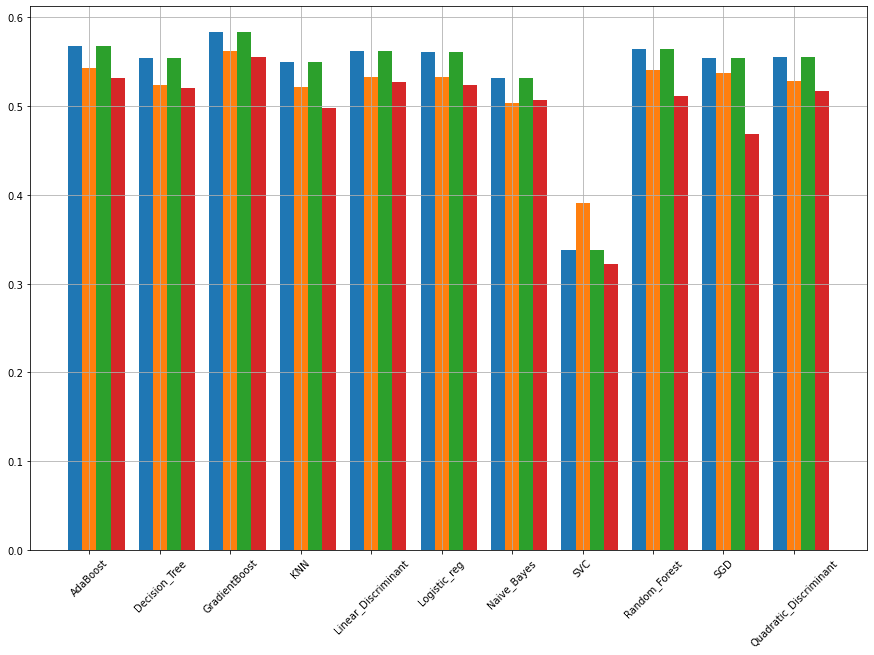

In [11]:
barWidth = 0.2
r1 = np.arange(len(df_metrics.Classifier))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(r1, df_metrics.Accuracy, width=0.2)
plt.bar(r2, df_metrics.Precision, width=0.2, tick_label=list(df_metrics.Classifier))
plt.xticks(rotation=45)
plt.bar(r3, df_metrics.Recall, width=0.2)
plt.bar(r4, df_metrics.F1Score, width=0.2)
plt.grid()

## WE can see that the best performance corresponds to  the GradientBoost, so we load it and see other metrics within it

[[14600  1510  1629]
 [ 5695  2535  2373]
 [ 3270  1381  5065]]


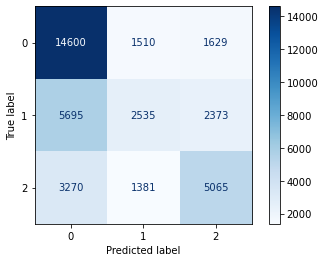

In [5]:
clf = load('Models/GradientBoost_model.joblib')
best_clf = clf.best_estimator_
disp = plot_confusion_matrix(best_clf, X_validation, y_validation,
                             cmap=plt.cm.Blues)
print(disp.confusion_matrix)

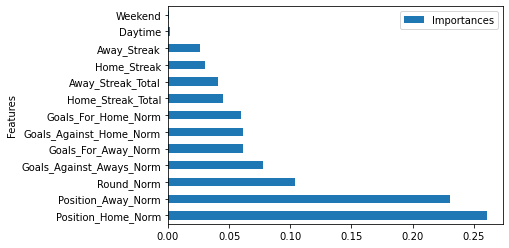

In [6]:
features = ['Position_Home_Norm', 'Position_Away_Norm', 'Goals_For_Home_Norm', 'Goals_Against_Home_Norm','Goals_For_Away_Norm', 'Goals_Against_Aways_Norm', 'Round_Norm', 'Home_Streak', 'Away_Streak','Home_Streak_Total', 'Away_Streak_Total', 'Weekend', 'Daytime']
feat_importance = best_clf.feature_importances_
df_features = pd.DataFrame({'Features': features, 'Importances': feat_importance})
df_features = df_features.sort_values('Importances', ascending = False)
ax = df_features.plot.barh(x='Features', y='Importances', rot=0)


In [24]:
y_proba = clf.predict_proba(X_validation)
y_val_linear = label_binarize(y_validation, classes=[0, 1, 2])
n_classes = y_val_linear.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_linear[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_val_linear.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

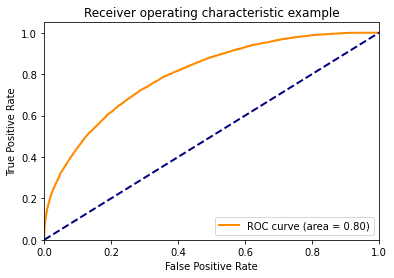

In [25]:
plt.figure()
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()